<a href="https://colab.research.google.com/github/nirb28/llm/blob/main/distillation/accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Calculate a Target Accuracy

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} \times100
$$

Calculating a base accuracy of Llama 3.1 405B vs the expectation from the dataset's labels gives us a target accuracy to aim for when training our student language model

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from common.utils import get_project_root

# Load your updated CSV file
df = pd.read_csv(str(get_project_root())+"/data/tweet_sentiment/test_groq_llama8b.csv")

# Calculate accuracy
accuracy = accuracy_score(df['label_text'], df['Llama_405B_label_text'])

print(f"Accuracy of Llama 3.1 405B: {accuracy:.2%}")

Accuracy of Llama 3.1 405B: 65.12%


---
# Training Student Model

Our student model will be [FacebookAI/roberta-base](https://huggingface.co/FacebookAI/roberta-base), a 125 million parameter language model. We'll be fine tuning this model on our Llama 3.1 405B annotated data using [AutoTrain Adance](https://github.com/huggingface/autotrain-advanced), HuggingFaces' packaged opensource solution for lowcode model training. They make it as easy as possible to run on local hardware, or via GPU accelerator platforms like Google's Colab or [HuggingFace Spaces](https://huggingface.co/autotrain).

We'll be using the *train* segment of the annotations generated, specifically the text from the original tweets and label as the Llama 3.1 405B generated label, passing in these hyperparameters (AutoTrain format)

```python
{
  "auto_find_batch_size": "false",
  "eval_strategy": "epoch",
  "mixed_precision": "fp16",
  "optimizer": "adamw_torch",
  "scheduler": "linear",
  "batch_size": "16",
  "early_stopping_patience": "5",
  "early_stopping_threshold": "0.01",
  "epochs": "5",
  "gradient_accumulation": "1",
  "lr": "0.00005",
  "logging_steps": "-1",
  "max_grad_norm": "1",
  "max_seq_length": "128",
  "save_total_limit": "1",
  "seed": "42",
  "warmup_ratio": "0.1",
  "weight_decay": "0"
}
```

Final trained model published at [AdamLucek/roberta-llama3.1405B-twitter-sentiment](https://huggingface.co/AdamLucek/roberta-llama3.1405B-twitter-sentiment)

---
# Testing Out the Fine Tuned Model

We'll be using [HuggingFace's Transformers Package Pipelines](https://huggingface.co/docs/transformers/en/main_classes/pipelines) to easily load and run inference using our trained model

In [1]:
from transformers import pipeline
pipe = pipeline("text-classification")
pipe("hi")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

C:\Users\dalje\.conda\envs\llm-dev-env\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dalje\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

C:\Users\dalje\.conda\envs\llm-dev-env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[{'label': 'POSITIVE', 'score': 0.9983267188072205}]

In [2]:
from transformers import pipeline
# Create sentiment Analysis pipeline
#student_classifier = pipeline("sentiment-analysis", model="AdamLucek/roberta-llama3.1405B-twitter-sentiment")
student_classifier = pipeline("sentiment-analysis", model="daljeetsingh/autotrain-roberta-sentiment")
#roberta_classifier = pipeline("sentiment-analysis", model="FacebookAI/roberta-base")

In [3]:
student_classifier("Want to get a Blackberry but can`t afford it. Just watching the telly and relaxing. Hard sesion tomorrow.")

[{'label': 'neutral', 'score': 0.5653103590011597}]

In [4]:
import json, csv
from common.utils import get_project_root

def process_csv(input_file, output_file):
    i = 0
    with open(input_file, 'r', newline='', encoding='utf-8') as infile, \
         open(output_file, 'w', newline='', encoding='utf-8') as outfile:

        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames + ['student_label_text']

        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            try:
                # Invoke the chain with the text from the current row
                response = student_classifier(row['text'])
                result = json.loads(response) if isinstance(response, str) else response

                # Add new fields to the row
                row['student_label_text'] = result[0]['label']

                # Write the updated row to the output file immediately
                writer.writerow(row)

                # Flush the write buffer to ensure data is written to disk
                outfile.flush()

                i+=1
                print(f"{i} - Processed and saved row with id: {row['id']}")
                
            except Exception as e:
                # Error handling
                print(f"Error processing row with id {row.get('id', 'unknown')}: {str(e)}")
                print(e)
                break
                continue

    print(f"Processing completed. Output saved to: {output_file}")

# Usage
input_file = str(get_project_root())+"/data/tweet_sentiment/test_groq_llama8b.csv"
output_file = str(get_project_root())+"/data/tweet_sentiment/test_groq_llama8b_student.csv"

process_csv(input_file, output_file)

1 - Processed and saved row with id: 9c825ecb4b
2 - Processed and saved row with id: 17fcf9a88f
3 - Processed and saved row with id: 67e69018ab
4 - Processed and saved row with id: 1e4a899d6e
5 - Processed and saved row with id: efe8ee16b9
6 - Processed and saved row with id: 17f403bfbd
7 - Processed and saved row with id: 53f412095b
8 - Processed and saved row with id: 709a86fd4a
9 - Processed and saved row with id: 1407d73622
10 - Processed and saved row with id: 967f203b7c
11 - Processed and saved row with id: 33a8872ade
12 - Processed and saved row with id: 3d5b85833e
13 - Processed and saved row with id: 22313620e6
14 - Processed and saved row with id: 719310ab14
15 - Processed and saved row with id: fa2e1c027e
16 - Processed and saved row with id: 65a9dd6348
17 - Processed and saved row with id: 1c71a17783
18 - Processed and saved row with id: f6e929a6ac
19 - Processed and saved row with id: b67e7e9504
20 - Processed and saved row with id: c36155ddc2
21 - Processed and saved row 

---
# Visualizing Accuracy

Now to calculate and compare our fine tuned model's accuracy to compare to LLama 3.1 405B. For fun, also ran tests using [GPT-4o-Mini](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/) and a [generalized multilingual sentiment model of similar size](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student).

In [25]:
# Calculate accuracy
import pandas as pd
from sklearn.metrics import accuracy_score
result_df = pd.read_csv(str(get_project_root())+"/data/tweet_sentiment/test_groq_llama8b_student.csv")

llama31_405B_accuracy = accuracy_score(result_df['label_text'], result_df['Llama_405B_label_text'])
#gpt4omini_accuracy = accuracy_score(result_df['label_text'], result_df['GPT4o_mini_label'])
ft_roberta = accuracy_score(result_df['label_text'], result_df['student_label_text'])
#multilingual = accuracy_score(result_df['label_text'], result_df['ML_Roberta'])

### Accuracy Graph

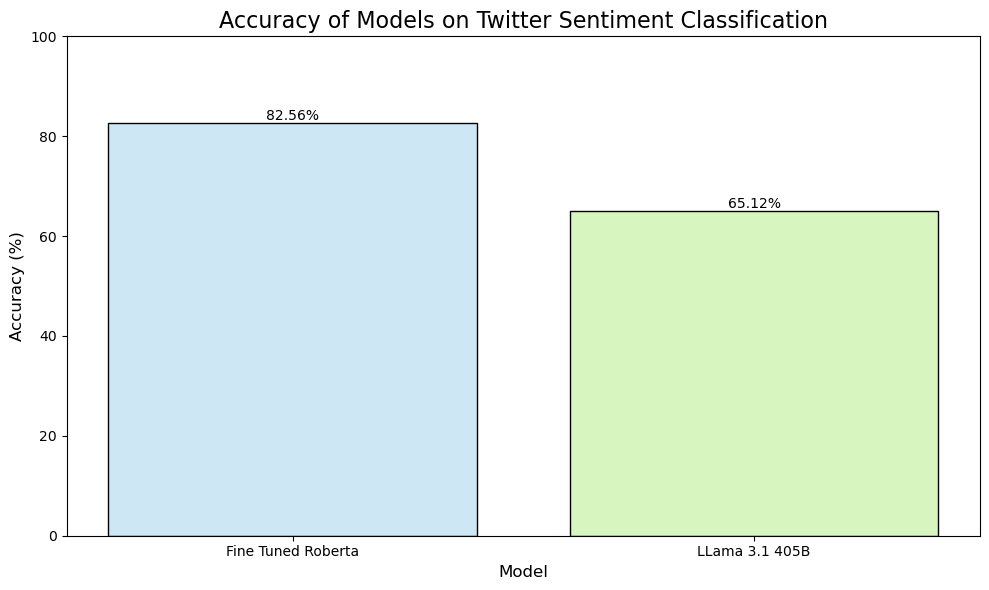

In [26]:
import matplotlib.pyplot as plt

# Data
models = ['LLama 3.1 405B', 'Fine Tuned Roberta']
accuracies = [llama31_405B_accuracy, ft_roberta]

# Convert accuracies to percentages
percentages = [acc * 100 for acc in accuracies]

# Combine models and percentages into a list of tuples, sort by accuracy in descending order
sorted_data = sorted(zip(models, percentages), key=lambda x: x[1], reverse=True)
sorted_models, sorted_percentages = zip(*sorted_data)

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_models, sorted_percentages, color=['#cde8f4', '#d6f5bf', '#fdd1d1', '#e3d9f0'], edgecolor='black', linewidth=1)
plt.title("Accuracy of Models on Twitter Sentiment Classification", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(0, 100)  # Set y-axis range from 0 to 100%

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height:.2f}%',
             ha='center', va='bottom')

# Display
plt.tight_layout()
plt.show()

Roughly the same performance at **0.03%** the size!

### Count of Sentiments

Also interesting to consider the distribution of sentiment labels across these models

In [ ]:
# List of models and their corresponding label columns
models = {
    'Llama 3.1 405B': 'Llama_405B_label_text',
    'Roberta FineTune': 'Roberta_FT',
    'Multilingual Distilbert': 'ML_Roberta',
    'GPT 4o Mini': 'GPT4o_mini_label'
}

# Calculating counts
label_counts = {model: {'positive': 0, 'neutral': 0, 'negative': 0} for model in models.keys()}
for model, column in models.items():
    label_counts[model]['positive'] = result_df[result_df[column] == 'positive'].shape[0]
    label_counts[model]['neutral'] = result_df[result_df[column] == 'neutral'].shape[0]
    label_counts[model]['negative'] = result_df[result_df[column] == 'negative'].shape[0]

# Create a DataFrame for plotting
counts_df = pd.DataFrame(label_counts).T

# Plotting with outlines
ax = counts_df.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 7),
    color=['#b3e8d1', '#fccbb2', '#c7d4eb'],
    edgecolor='black'
)

# Add counts on the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width/2,
            y + height/2,
            f'{int(height)}',
            ha='center',
            va='center')

plt.title('Label Counts per Model')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Label')
plt.show()

---
# Addtional Notes:


Consider the costs:
* ~\$0.08 for gpt4o via OpenAI
* ~$1.80 for Llama 3.1 405B via Fireworks

And consider the time cost too! Much slower inference with the foundational models compared to the distilled language model.

Note that we are not aiming for higher accuracy here, rather a standard metric to assess our fine tuned model to see if it performs now as well as the foundation model

And a big shoutout to Moritz Laurer for the https://huggingface.co/blog/synthetic-data-save-costs blog, much of which the primary methodology that guided this notebook was heavily inspired by.